<a href="https://colab.research.google.com/github/Remian-9080/An-Evaluation-Pipeline/blob/main/Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
# Assuming your JSON files are named model_1.json, model_2.json, etc.
# And each file contains 100 entries for one specific response model
json_files = {
    "Gpt-4": "model_responses(Gpt-4).json",
    "Gemini Pro": "model_responses(Gemini Pro).json",
    "Llama3": "model_responses(Llama3).json",
    "Mistral-7B": "model_responses(Mistral 7B).json",
}

# --- Load Data ---
all_data = []
for model_name, file_path in json_files.items():
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        # Add a 'source_file_model' field to know which JSON file it came from
        for entry in data:
            entry['source_file_model'] = model_name
            all_data.append(entry)

df = pd.DataFrame(all_data)

# Verify loaded data structure
print("--- Initial DataFrame Head ---")
print(df.head())
print(f"\nTotal entries loaded: {len(df)}")
print(f"Unique questions: {df['question_no'].nunique()}")
print(f"Unique responding models: {df['Responsed_model'].nunique()}")

# Crucial: Ensure each question has a response from each of your 4 models
# If 'Responsed_model' field directly maps to your 4 models, that's perfect.
# If 'Responsed_model' is just a placeholder name like "Gemini Pro", you should map it back to "Model_1", "Model_2", etc.
# Based on your example, it seems 'Responsed_model' will contain "Gemini Pro", "GPT-4", "Claude", etc.
# So we need to group by 'question_no' and then iterate through the responses for each question.

--- Initial DataFrame Head ---
   question_no  data_chuck model(q)  \
0            1           1    GPT-4   
1            2           1    GPT-4   
2            3           1    GPT-4   
3            4           1    GPT-4   
4            5           1    GPT-4   

                                            question Responsed_model  \
0  What percentage of GDP did Bangladesh spend on...           GPT-4   
1  According to the Human Rights Measurement Init...           GPT-4   
2  How much of the right to health for children i...           GPT-4   
3  What is the percentage of right to health fulf...           GPT-4   
4  What percentage of expected reproductive healt...           GPT-4   

                                      model_response source_file_model  
0  In 2019, Bangladesh spent 2.34% of its GDP on ...             Gpt-4  
1  According to the Human Rights Measurement Init...             Gpt-4  
2  As an AI language model, I don't have real-tim...             Gpt-4  
3  I'm so

In [ ]:
# Pivot the DataFrame to have one row per question, with columns for each model's response
# This assumes 'Responsed_model' has distinct names like 'Gemini Pro', 'GPT-4', 'Claude', 'Llama' etc.
# If your JSON files contain entries where 'Responsed_model' refers to the model of that *file*,
# then you'd use 'source_file_model' here. Let's assume 'Responsed_model' directly gives the model's name.

# Get the list of actual responding model names from your data
responding_models = df['Responsed_model'].unique()
print(f"\nResponding Models found in data: {responding_models}")

# It's safer to use 'source_file_model' if each JSON file corresponds to one model's output
# Let's pivot using 'source_file_model' for clarity since you named your files Model_1.json, Model_2.json etc.
df_pivoted = df.pivot_table(index=['question_no', 'question'],
                            columns='source_file_model',
                            values='model_response',
                            aggfunc='first') # Use 'first' if there are multiple identical entries for a question/model
df_pivoted = df_pivoted.reset_index()

# Rename columns to be cleaner, e.g., 'Model_1_Response', 'Model_2_Response'
df_pivoted.columns.name = None # Remove the 'source_file_model' column name
new_column_names = {col: f"{col}_Response" if col not in ['question_no', 'question'] else col for col in df_pivoted.columns}
df_pivoted = df_pivoted.rename(columns=new_column_names)

# Define the columns that contain the actual responses
response_cols = [col for col in df_pivoted.columns if 'Response' in col]

print("\n--- Pivoted DataFrame Head (Ready for Embedding) ---")
print(df_pivoted.head())
print(f"\nNumber of questions for analysis: {len(df_pivoted)}")

# --- Generate Embeddings ---
model = SentenceTransformer('all-MiniLM-L6-v2')

# Store embeddings for each question
question_embeddings = {} # Key: question_no, Value: dictionary {model_name: embedding}

for index, row in df_pivoted.iterrows():
    question_id = row['question_no']
    current_question_embeddings = {}
    for col in response_cols:
        model_name = col.replace('_Response', '')
        response_text = row[col]
        # Handle potential NaN values if some questions don't have responses from all models
        if pd.isna(response_text):
            print(f"Warning: Missing response for Question {question_id} from {model_name}. Skipping embedding for this one.")
            current_question_embeddings[model_name] = None
        else:
            embedding = model.encode(response_text, convert_to_tensor=True)
            current_question_embeddings[model_name] = embedding
    question_embeddings[question_id] = current_question_embeddings

print(f"\nEmbeddings generated for {len(question_embeddings)} questions.")


Responding Models found in data: ['GPT-4' 'Gemini Pro' 'Llama3' 'Mistral 7b']

--- Pivoted DataFrame Head (Ready for Embedding) ---
   question_no                                           question  \
0            1  What percentage of GDP did Bangladesh spend on...   
1            2  According to the Human Rights Measurement Init...   
2            3  How much of the right to health for children i...   
3            4  What is the percentage of right to health fulf...   
4            5  What percentage of expected reproductive healt...   

                                 Gemini Pro_Response  \
0  Based on information regarding Bangladesh's he...   
1  The Human Rights Measurement Initiative assess...   
2  Similar to the general right to health, the Hu...   
3  The Human Rights Measurement Initiative's data...   
4  Bangladesh's fulfillment of expected reproduct...   

                                      Gpt-4_Response  \
0  In 2019, Bangladesh spent 2.34% of its GDP on ...   
1  

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
import torch
print("\n--- Phase 1: Per-Question Divergence Metrics ---")

divergence_results = []
model_names_list = [col.replace('_Response', '') for col in response_cols] # e.g., ['Model_1', 'Model_2', 'Model_3', 'Model_4']

for q_id, embeddings_dict in question_embeddings.items():
    available_embeddings = []
    available_models_for_q = []

    for m_name in model_names_list:
        if embeddings_dict[m_name] is not None:
            available_embeddings.append(embeddings_dict[m_name])
            available_models_for_q.append(m_name)

    if len(available_embeddings) < 2: # Need at least two responses to compare
        print(f"Skipping Question {q_id}: Not enough responses to compare (only {len(available_embeddings)}).")
        continue

    # Calculate similarity matrix for this question's responses
    q_sim_matrix = util.cos_sim(torch.stack(available_embeddings), torch.stack(available_embeddings)) # Stack for matrix calculation

    # Extract upper triangle (excluding diagonal) for unique pairwise similarities
    pairwise_sims = []
    for i in range(len(available_models_for_q)):
        for j in range(i + 1, len(available_models_for_q)):
            pairwise_sims.append(q_sim_matrix[i][j].item())

    min_sim = np.min(pairwise_sims) if pairwise_sims else np.nan
    max_sim = np.max(pairwise_sims) if pairwise_sims else np.nan
    avg_sim = np.mean(pairwise_sims) if pairwise_sims else np.nan

    # Store individual pairwise similarities for more detailed analysis if needed
    individual_sims = {}
    for i in range(len(available_models_for_q)):
        for j in range(i + 1, len(available_models_for_q)):
            m1 = available_models_for_q[i]
            m2 = available_models_for_q[j]
            individual_sims[f"{m1}_vs_{m2}"] = q_sim_matrix[i][j].item()


    divergence_results.append({
        "question_no": q_id,
        "question_text": df_pivoted[df_pivoted['question_no'] == q_id]['question'].iloc[0],
        "avg_pairwise_similarity": avg_sim,
        "min_pairwise_similarity": min_sim,
        "max_pairwise_similarity": max_sim,
        **individual_sims # Unpack individual similarities
    })

divergence_df = pd.DataFrame(divergence_results)

print("\n--- Divergence Metrics Per Question (Head) ---")
print(divergence_df.head())
print(f"\nNumber of questions analyzed for divergence: {len(divergence_df)}")

# --- Identifying Potential Hallucinations ---
divergence_threshold = 0.5 # Example: If any pair is below this, it's a flag
hallucination_flags = divergence_df[divergence_df['min_pairwise_similarity'] < divergence_threshold]

print(f"\n--- Questions Potentially Containing Hallucinations (min_pairwise_similarity < {divergence_threshold}) ---")
if not hallucination_flags.empty:
    print(hallucination_flags[['question_no', 'question_text', 'min_pairwise_similarity']].to_string())
else:
    print("No questions flagged based on the current divergence threshold.")

# Save this DataFrame for later inspection
divergence_df.to_csv("per_question_divergence.csv", index=False)
print("\nPer-question divergence results saved to 'per_question_divergence.csv'")


--- Phase 1: Per-Question Divergence Metrics ---

--- Divergence Metrics Per Question (Head) ---
   question_no                                      question_text  \
0            1  What percentage of GDP did Bangladesh spend on...   
1            2  According to the Human Rights Measurement Init...   
2            3  How much of the right to health for children i...   
3            4  What is the percentage of right to health fulf...   
4            5  What percentage of expected reproductive healt...   

   avg_pairwise_similarity  min_pairwise_similarity  max_pairwise_similarity  \
0                 0.885857                 0.844207                 0.950253   
1                 0.854058                 0.808738                 0.917553   
2                 0.814799                 0.747062                 0.893006   
3                 0.800199                 0.682338                 0.895313   
4                 0.749960                 0.675015                 0.882781   

   Gem


--- Phase 1: Model-to-Model Average Similarity (Heatmap Data) ---

--- Average Similarity Matrix Between Models ---
            Gemini Pro  Gpt-4  Llama3  Mistral-7B
Gemini Pro       1.000  0.865   0.830       0.827
Gpt-4            0.865  1.000   0.853       0.851
Llama3           0.830  0.853   1.000       0.850
Mistral-7B       0.827  0.851   0.850       1.000

Average model similarity matrix saved to 'avg_model_similarity_matrix.csv'


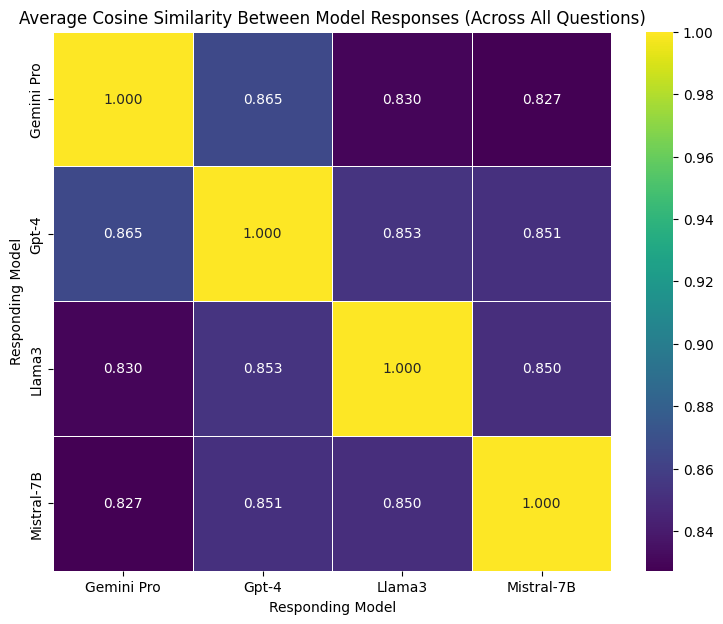

In [ ]:
print("\n--- Phase 1: Model-to-Model Average Similarity (Heatmap Data) ---")

# Prepare a matrix to store average similarities
avg_sim_matrix = pd.DataFrame(index=model_names_list, columns=model_names_list, dtype=float)

for m1_name in model_names_list:
    for m2_name in model_names_list:
        if m1_name == m2_name:
            avg_sim_matrix.loc[m1_name, m2_name] = 1.0 # Self-similarity is always 1
            continue

        similarities_for_pair = []
        for q_id, embeddings_dict in question_embeddings.items():
            emb1 = embeddings_dict.get(m1_name)
            emb2 = embeddings_dict.get(m2_name)
            if emb1 is not None and emb2 is not None:
                sim = util.cos_sim(emb1, emb2).item()
                similarities_for_pair.append(sim)

        avg_sim_matrix.loc[m1_name, m2_name] = np.mean(similarities_for_pair) if similarities_for_pair else np.nan

print("\n--- Average Similarity Matrix Between Models ---")
print(avg_sim_matrix.round(3)) # Round for cleaner display

# Save this DataFrame
avg_sim_matrix.to_csv("avg_model_similarity_matrix.csv")
print("\nAverage model similarity matrix saved to 'avg_model_similarity_matrix.csv'")

# --- Plotting the Heatmap ---
plt.figure(figsize=(9, 7))
sns.heatmap(avg_sim_matrix, annot=True, cmap='viridis', fmt=".3f", linewidths=.5)
plt.title('Average Cosine Similarity Between Model Responses (Across All Questions)')
plt.xlabel('Responding Model')
plt.ylabel('Responding Model')
plt.show()

In [ ]:
import plotly.express as px
import pandas as pd
import numpy as np

# Assuming 'divergence_df' is already loaded or generated
# If starting fresh in a new session:
# divergence_df = pd.read_csv("per_question_divergence.csv")

# --- Define the two divergence thresholds ---
strict_threshold = 0.70
warning_threshold = 0.85


# --- Categorize questions by divergence similarity ---
def categorize_divergence(min_sim):
    if min_sim < strict_threshold:
        return "High Divergence (Hallucination Likely)"
    elif min_sim < warning_threshold:
        return "Review Needed"
    else:
        return "Highly Consistent"

divergence_df['divergence_category'] = divergence_df['min_pairwise_similarity'].apply(categorize_divergence)

# Ensure 'marker_size' is non-negative
divergence_df['marker_size'] = divergence_df['min_pairwise_similarity'].clip(lower=0)

# --- Categorize questions by Theme ---
def assign_theme_category(question_no):
    if 1 <= question_no <= 25:
        return "1. Health Rights, Infrastructure"
    elif 26 <= question_no <= 50:
        return "2. Chikungunya & Dengue Outbreaks"
    elif 51 <= question_no <= 75:
        return "3. Maternal & Child Health Policies"
    elif 76 <= question_no <= 100:
        return "4. COVID-19 & Air Pollution"
    else:
        return "Other" # Fallback for unexpected question numbers

divergence_df['theme_category'] = divergence_df['question_no'].apply(assign_theme_category)

# Prepare custom hover data (same as before)
hover_cols = ['question_no', 'question_text', 'avg_pairwise_similarity', 'min_pairwise_similarity', 'divergence_category', 'theme_category']
model_names_list = [col.replace('_Response', '') for col in [f"Model_{i}_Response" for i in range(1, 5)] if col in divergence_df.columns]
for i in range(len(model_names_list)):
    for j in range(i + 1, len(model_names_list)):
        col_name = f"{model_names_list[i]}_vs_{model_names_list[j]}"
        if col_name in divergence_df.columns:
            hover_cols.append(col_name)

# Create the interactive scatter plot with faceting by theme
fig = px.scatter(
    divergence_df,
    x='question_no',
    y='min_pairwise_similarity',
    color='divergence_category', # Color points by divergence category (Red, Orange, Blue)
    color_discrete_map={
        "Highly Consistent": "blue",
        "Review Needed": "orange",
        "High Divergence (Hallucination Likely)": "red"
    },
    size='marker_size', # Use the clipped size
    size_max=15,
    hover_name='question_no',
    hover_data=hover_cols,
    title='Question Consistency by Theme and Divergence Category',
    labels={
        'question_no': 'Question Number',
        'min_pairwise_similarity': 'Minimum Pairwise Cosine Similarity',
        'divergence_category': 'Divergence Category'
    },
    # --- Facet by 'theme_category' ---
    facet_col='theme_category',
    facet_col_wrap=2, # For a 2x2 grid
    height=600,
    width=1000
)

# Clean up facet titles (e.g., remove 'theme_category=')
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("theme_category=", "")))

# --- CORRECTED: Add horizontal lines to *each subplot* (facet) ---
# This method directly constructs the axis names based on the facet_col_wrap and subplot index.
# This avoids relying on the exact internal structure of _grid_ref which can vary.

num_themes = len(divergence_df['theme_category'].unique())
num_facet_cols = 2  # As defined by facet_col_wrap

for i in range(num_themes):
    subplot_idx = i + 1  # Subplot indices are 1-based

    # ✅ Correct: use x, x2, y, y2 for shapes/annotations
    xref_name = f'x{subplot_idx}' if subplot_idx > 1 else 'x'
    yref_name = f'y{subplot_idx}' if subplot_idx > 1 else 'y'

    # Add strict threshold line
    fig.add_shape(
        type="line",
        x0=0, x1=1, xref=xref_name + " domain",
        y0=strict_threshold, y1=strict_threshold, yref=yref_name,
        line=dict(color="red", dash="dot"),
        layer="below"
    )

    # Add warning threshold line
    fig.add_shape(
        type="line",
        x0=0, x1=1, xref=xref_name + " domain",
        y0=warning_threshold, y1=warning_threshold, yref=yref_name,
        line=dict(color="orange", dash="dot"),
        layer="below"
    )

    # Add annotation for strict line
    fig.add_annotation(
        xref=xref_name, yref=yref_name,
        x=1, y=strict_threshold,
        text=f"Strict ({strict_threshold:.2f})",
        showarrow=False,
        font=dict(color="red", size=10),
        xanchor="right", yanchor="bottom"
    )

    # Add annotation for warning line
    fig.add_annotation(
        xref=xref_name, yref=yref_name,
        x=1, y=warning_threshold,
        text=f"Warning ({warning_threshold:.2f})",
        showarrow=False,
        font=dict(color="orange", size=10),
        xanchor="right", yanchor="top"
    )


# Customize the layout
fig.update_xaxes(title_text='Question Number') # Global x-axis title
fig.update_yaxes(title_text='Min Pairwise Cosine Similarity', range=[0, 1.05]) # Global y-axis title and range
fig.update_layout(hovermode='closest')


# Show the plot
fig.show()

# You can also save the DataFrame with the new category
# divergence_df.to_csv("per_question_divergence_categorized_themed.csv", index=False)
# print("\nCategorized and themed divergence results saved to 'per_question_divergence_categorized_themed.csv'")

In [ ]:
import plotly.express as px
import pandas as pd
import numpy as np

# Assuming 'divergence_df' is already loaded or generated.
# (The code to load/create divergence_df is omitted here for brevity,
# but ensure it runs before this section in your actual script/notebook.)


# --- Define the two divergence thresholds ---
strict_threshold = 0.70
warning_threshold = 0.85

# --- Categorize questions by divergence similarity ---
def categorize_divergence(min_sim):
    if min_sim < strict_threshold:
        return "High Divergence (Hallucination Likely)"
    elif min_sim < warning_threshold:
        return "Review Needed"
    else:
        return "Highly Consistent"

divergence_df['divergence_category'] = divergence_df['min_pairwise_similarity'].apply(categorize_divergence)

# Ensure 'marker_size' is non-negative
divergence_df['marker_size'] = divergence_df['min_pairwise_similarity'].clip(lower=0)

# --- Categorize questions by Theme ---
def assign_theme_category(question_no):
    if 1 <= question_no <= 25:
        return "1. Health Rights, Infrastructure"
    elif 26 <= question_no <= 50:
        return "2. Chikungunya & Dengue Outbreaks"
    elif 51 <= question_no <= 75:
        return "3. Maternal & Child Health Policies"
    elif 76 <= question_no <= 100:
        return "4. COVID-19 & Air Pollution"
    else:
        return "Other" # Fallback for unexpected question numbers

divergence_df['theme_category'] = divergence_df['question_no'].apply(assign_theme_category)


# --- Calculate counts by divergence category ---
print("\n--- Counts of Questions by Divergence Category ---")
divergence_counts = divergence_df['divergence_category'].value_counts()
print(divergence_counts)

# --- Optional: Calculate percentages ---
print("\n--- Percentages of Questions by Divergence Category ---")
divergence_percentages = divergence_df['divergence_category'].value_counts(normalize=True) * 100
print(divergence_percentages.round(2).astype(str) + '%')


# --- Optional: Breakdown by Theme Category as well ---
print("\n--- Counts of Questions by Divergence Category and Theme ---")
divergence_counts_by_theme = divergence_df.groupby('theme_category')['divergence_category'].value_counts().unstack(fill_value=0)
print(divergence_counts_by_theme)

# --- Optional: Percentages by Theme Category ---
print("\n--- Percentages of Questions by Divergence Category (within each Theme) ---")
divergence_percentages_by_theme = divergence_df.groupby('theme_category')['divergence_category'].value_counts(normalize=True).unstack(fill_value=0) * 100
print(divergence_percentages_by_theme.round(2).astype(str) + '%') # CORRECTED LINE

# The plotting code (from the previous answer) would follow here if you want to run it.
# ... (your plotting code for the faceted scatter plot) ...


--- Counts of Questions by Divergence Category ---
divergence_category
Review Needed                             61
Highly Consistent                         20
High Divergence (Hallucination Likely)    19
Name: count, dtype: int64

--- Percentages of Questions by Divergence Category ---
divergence_category
Review Needed                             61.0%
Highly Consistent                         20.0%
High Divergence (Hallucination Likely)    19.0%
Name: proportion, dtype: object

--- Counts of Questions by Divergence Category and Theme ---
divergence_category                  High Divergence (Hallucination Likely)  \
theme_category                                                                
1. Health Rights, Infrastructure                                          5   
2. Chikungunya & Dengue Outbreaks                                         5   
3. Maternal & Child Health Policies                                       4   
4. COVID-19 & Air Pollution                              